In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn as skn

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error

from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA as pca
from sklearn.preprocessing import OneHotEncoder


import warnings
warnings.filterwarnings('ignore')

In [2]:
rs = 42

df = pd.read_csv('NY-House-Dataset.csv')
df.columns

Index(['BROKERTITLE', 'TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT',
       'ADDRESS', 'STATE', 'MAIN_ADDRESS', 'ADMINISTRATIVE_AREA_LEVEL_2',
       'LOCALITY', 'SUBLOCALITY', 'STREET_NAME', 'LONG_NAME',
       'FORMATTED_ADDRESS', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [3]:
df.describe()

,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
count,4.801000e+03,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000
mean,2.356940e+06,3.356801,2.373861,2184.207862,40.714227,-73.941601
std,3.135525e+07,2.602315,1.946962,2377.140894,0.087676,0.101082
min,2.494000e+03,1.000000,0.000000,230.000000,40.499546,-74.253033
25%,4.990000e+05,2.000000,1.000000,1200.000000,40.639375,-73.987143
50%,8.250000e+05,3.000000,2.000000,2184.207862,40.726749,-73.949189
75%,1.495000e+06,4.000000,3.000000,2184.207862,40.771923,-73.870638
max,2.147484e+09,50.000000,50.000000,65535.000000,40.912729,-73.702450


In [4]:
sel_cols = ['TYPE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'PRICE']
df = df[sel_cols]
df.head()

,TYPE,BEDS,BATH,PROPERTYSQFT,PRICE
0,Condo for sale,2,2.000000,1400.0,315000
1,Condo for sale,7,10.000000,17545.0,195000000
2,House for sale,4,2.000000,2015.0,260000
3,Condo for sale,3,1.000000,445.0,69000
4,Townhouse for sale,7,2.373861,14175.0,55000000


In [5]:
df.TYPE.unique()

array(['Condo for sale', 'House for sale', 'Townhouse for sale',
       'Co-op for sale', 'Multi-family home for sale', 'For sale',
       'Contingent', 'Land for sale', 'Foreclosure', 'Pending',
       'Coming Soon', 'Mobile house for sale', 'Condop for sale'],
      dtype=object)

In [6]:
df.isna().sum()

TYPE            0
BEDS            0
BATH            0
PROPERTYSQFT    0
PRICE           0
dtype: int64

In [7]:
df['TYPE'] = df['TYPE'].str.replace(' for sale' , '')
df.loc[df['TYPE'] == 'Condop' , 'TYPE'] = 'Condo'
df.TYPE.value_counts()

TYPE
Co-op                1450
House                1012
Condo                 896
Multi-family home     727
Townhouse             299
Pending               243
Contingent             88
Land                   49
For sale               20
Foreclosure            14
Coming Soon             2
Mobile house            1
Name: count, dtype: int64

In [8]:
keep_types = ['Co-op' , 'House' , 'Condo' , 'Multi-family home', 'Townhouse']
df = df[df.TYPE.isin(keep_types)]

df.describe()

,BEDS,BATH,PROPERTYSQFT,PRICE
count,4384.000000,4384.000000,4384.000000,4.384000e+03
mean,3.369982,2.384720,2198.844372,2.463063e+06
std,2.677165,2.002288,2460.376400,3.280341e+07
min,1.000000,0.000000,250.000000,4.950000e+04
25%,2.000000,1.000000,1199.500000,4.990000e+05
50%,3.000000,2.000000,2184.207862,8.480000e+05
75%,4.000000,3.000000,2184.207862,1.500000e+06
max,50.000000,50.000000,65535.000000,2.147484e+09


In [9]:
# plot before preprocessing
fig = px.box(data_frame=df , x = 'TYPE' , y = 'PRICE' , color = 'TYPE')

fig.show()


In [10]:
lower_iqr = np.nanpercentile(df.PRICE , 25)
upper_iqr = np.nanpercentile(df.PRICE , 75)

iqr = upper_iqr - lower_iqr

lower_bound = lower_iqr - (1.5 * iqr)
upper_bound = upper_iqr + (1.5 * iqr)


df = df[(df['PRICE'] >= lower_bound) & (df['PRICE'] <= upper_iqr)]

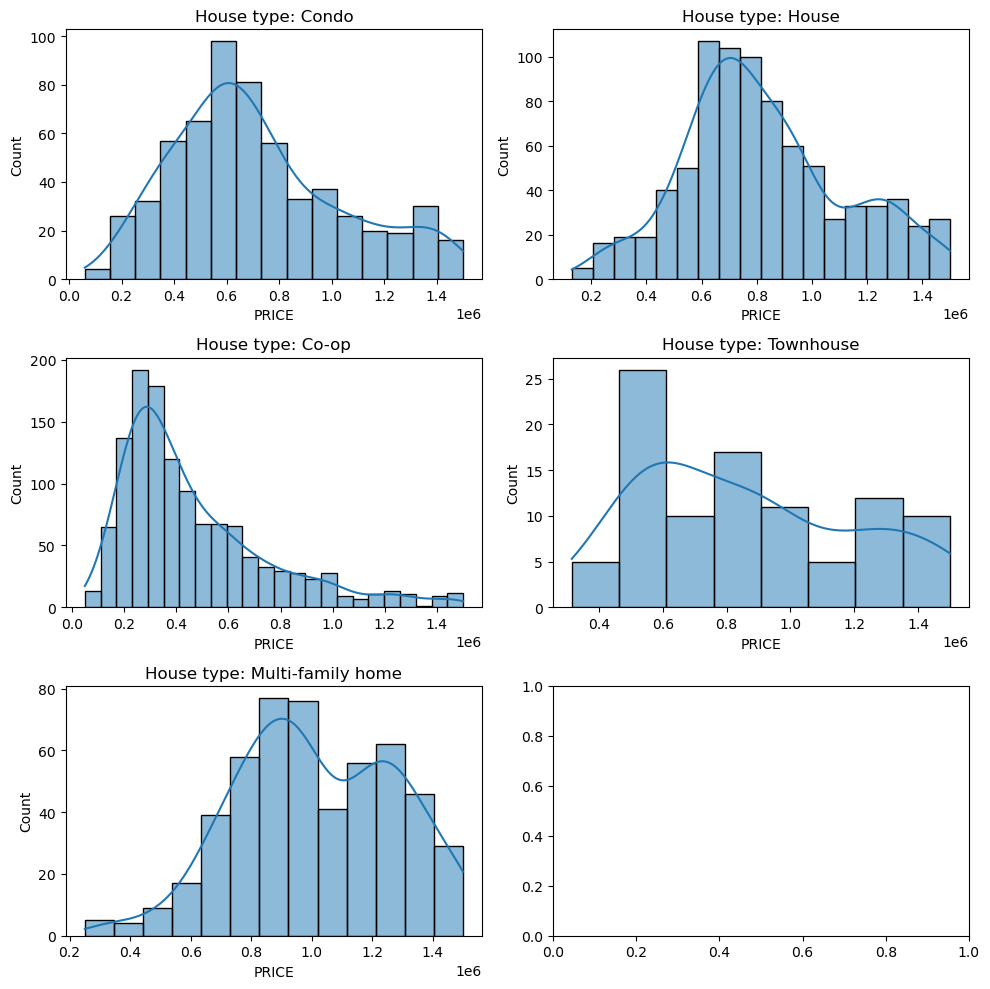

In [11]:
import seaborn as sns


house_types = df.TYPE.unique()

fig , axs = plt.subplots(3,2 , figsize = (10,10))

axs = axs.flatten()

for i in range(len(house_types)):
    sns.histplot(
        data=df[df["TYPE"] == house_types[i]],
        x="PRICE",
        kde=True,
        ax=axs[i]
    )
    axs[i].set_title(f"House type: {house_types[i]}")

plt.tight_layout()
plt.show()

In [12]:
fig = px.scatter(data_frame=df, x = 'PROPERTYSQFT', y = 'PRICE' , facet_col= 'TYPE' , trendline= 'lowess' , trendline_scope='overall')
fig.show()

In [13]:
fig = px.box(data_frame=df , x = 'TYPE' , y = 'PRICE' , color = 'TYPE')

fig.show()


In [14]:

from scipy.stats import ttest_ind
import itertools

house_types = df["TYPE"].unique()

res = []

# Compare all pairs of house types
for a, b in itertools.combinations(house_types, 2):
    prices_a = df[df["TYPE"] == a]["PRICE"]
    prices_b = df[df["TYPE"] == b]["PRICE"]
    t_stat, p_val = ttest_ind(prices_a, prices_b, equal_var=False)  # Welch’s t-test
    temp = {
        "comparison": f"{a} vs {b}",
        "t-stat": t_stat,
        "p-value": p_val
    }
    res.append(temp)

res = pd.DataFrame(res)

res

,comparison,t-stat,p-value
0,Condo vs House,-6.348985,3.068020e-10
1,Condo vs Co-op,15.957178,1.560503e-51
2,Condo vs Townhouse,-4.109664,7.134950e-05
3,Condo vs Multi-family home,-16.778841,1.678347e-56
4,House vs Co-op,27.380812,7.298844e-138
5,House vs Townhouse,-1.296410,1.975087e-01
6,House vs Multi-family home,-12.372849,3.852902e-33
7,Co-op vs Townhouse,-11.255541,8.662711e-20
8,Co-op vs Multi-family home,-38.400623,8.250204e-202
9,Townhouse vs Multi-family home,-3.922613,1.480341e-04


In [15]:
df.loc[df['TYPE'].isin(['House' , 'Condo']) , 'TYPE'] = 'Condo & House'


In [16]:
fig = px.box(data_frame=df , x = 'TYPE' , y = 'PRICE' , color = 'TYPE')

fig.show()

In [17]:
bath_price = df.groupby('BATH')['PRICE'].mean().reset_index()

# Reshape price for clustering
X = bath_price['PRICE'].values.reshape(-1, 1)

# Cluster into 4 groups
kmeans = KMeans(n_clusters=4, random_state=rs).fit(X)
bath_price['BATH_GROUP'] = kmeans.labels_

# Map back
bath_group_map = dict(zip(bath_price['BATH'], bath_price['BATH_GROUP']))
df['BATH_GROUP'] = df['BATH'].map(bath_group_map)



fig = px.box(data_frame=df, x = 'BATH_GROUP', y = 'PRICE' , color= 'BATH_GROUP' )
fig.show()

In [18]:
bath_groups = sorted(df['BATH_GROUP'].unique())

for group in bath_groups:
    print(f"Group {group}:")
    print(f"Unique bath values: {df[df['BATH_GROUP'] == group]['BATH'].unique().astype(str)}")

Group 0:
Unique bath values: ['3.0']
Group 1:
Unique bath values: ['6.0' '8.0' '4.0' '5.0' '9.0' '7.0']
Group 2:
Unique bath values: ['1.0']
Group 3:
Unique bath values: ['2.0' '2.3738608579684373']


In [19]:
# Get average price per bath type
bed_price = df.groupby('BEDS')['PRICE'].mean().reset_index()

# Reshape price for clustering
X = bed_price['PRICE'].values.reshape(-1, 1)

# Cluster into 5 groups
kmeans = KMeans(n_clusters=5, random_state=rs).fit(X)
bed_price['BEDS_GROUP'] = kmeans.labels_

# Map back
bed_group_map = dict(zip(bed_price['BEDS'], bed_price['BEDS_GROUP']))
df['BEDS_GROUP'] = df['BEDS'].map(bed_group_map)



fig = px.box(data_frame=df, x = 'BEDS_GROUP', y = 'PRICE' , color= 'BEDS_GROUP' )
fig.show()

In [20]:
bath_groups = sorted(df['BEDS_GROUP'].unique())

for group in bath_groups:
    print(f"Group {group}:")
    print(f"Unique bed values: {df[df['BEDS_GROUP'] == group]['BEDS'].unique().astype(str)}")

Group 0:
Unique bed values: ['4' '5' '6' '7' '8']
Group 1:
Unique bed values: ['2' '3']
Group 2:
Unique bed values: ['1']
Group 3:
Unique bed values: ['11' '9' '12' '15' '16' '13']
Group 4:
Unique bed values: ['10' '14']


In [21]:
df['combined_cols'] = df['BEDS_GROUP'].astype(str) + df['BATH_GROUP'].astype(str) + df['TYPE'].astype(str)
value_counts = df['combined_cols'].value_counts()
df = df[df['combined_cols'].isin(value_counts[value_counts >= 8].index)]
print(df.shape)

(3239, 8)


In [22]:
categorical_cols = ['BEDS_GROUP' , 'BATH_GROUP' , 'TYPE']

X = df.drop(columns = ['PRICE' ])
y = np.log(df['PRICE'])

for col in categorical_cols:
    X[col] = X[col].astype('category')
    X[col] = X[col].cat.codes



In [23]:
def make_scaler(feature):
    scaler = MinMaxScaler()
    feature = scaler.fit_transform(feature.values.reshape(-1, 1))
    return feature , scaler

In [24]:
X['Area'] = X['PROPERTYSQFT']
X['Area_sqrt'] = np.sqrt(X['Area'])
X['Area_log'] = np.log(X['Area'])
X['Area_2'] = X['Area'] ** 2
X['Area_3'] = X['Area'] ** 3


X_train, X_test, y_train, y_test = train_test_split(X , y , test_size = 0.25 , random_state = 42, stratify=X['combined_cols'])


X_train['Area'] , area_scaler = make_scaler(X_train['Area'])
X_train['Area_sqrt'] , area_sqrt_scaler = make_scaler(X_train['Area_sqrt'])
X_train['Area_log'] , area_log_scaler = make_scaler(X_train['Area_log'])
X_train['Area_2'] , area_2_scaler = make_scaler(X_train['Area_2'])
X_train['Area_3'] , area_3_scaler = make_scaler(X_train['Area_3'])

X_test['Area'] = area_scaler.transform(X_test['Area'].values.reshape(-1, 1))
X_test['Area_sqrt'] = area_sqrt_scaler.transform(X_test['Area_sqrt'].values.reshape(-1, 1))
X_test['Area_log'] = area_log_scaler.transform(X_test['Area_log'].values.reshape(-1, 1))
X_test['Area_2'] = area_2_scaler.transform(X_test['Area_2'].values.reshape(-1, 1)) 
X_test['Area_3'] = area_3_scaler.transform(X_test['Area_3'].values.reshape(-1, 1))


y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)) 
y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

drop_cols = ['BEDS' , 'BATH' , 'PROPERTYSQFT' , 'combined_cols']


X_train = X_train.drop(columns = drop_cols)
X_test = X_test.drop(columns = drop_cols)


In [25]:
pc = pca(
    copy=True,
    random_state=42
)

pc = pc.fit(X_train)

pc_var = pd.DataFrame(np.round(pc.explained_variance_ratio_ , 10) , columns=['explained_variance'])
pc_var['explained_variance_cumulative'] = pc_var['explained_variance'].cumsum()
pc_var['PC'] = pc_var.index + 1


fig = px.line(data_frame=pc_var , x = 'PC' , y = 'explained_variance_cumulative' , title = 'Explained variance by each PC')
fig.show()



In [26]:
pc = pca(
    n_components=2,
    copy=True,
    random_state=42
)

pc = pc.fit(X_train)

In [27]:
X_train = pc.transform(X_train )
X_test = pc.transform(X_test)



print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2429, 2)
y_train shape: (2429, 1)
X_test shape: (810, 2)
y_test shape: (810, 1)


In [28]:
def train_and_evaluate_model(model, scaler , X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    

    y_train_pred = model.predict(X_train)
    y_train_pred = y_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

    
    y_test_pred = model.predict(X_test)
    y_test_pred = y_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
    
    
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    
    ret = {
        'model_name' : type(model).__name__ , 
        'y_train_pred' : y_train_pred,
        'y_test_pred' : y_test_pred,
        'test_rmse' : rmse,
        'test_mape' : mape 
        
    }
    
    
    return ret

In [29]:
models = [
         LinearRegression(),
         DecisionTreeRegressor(criterion= 'squared_error' , max_depth = 5),
         RandomForestRegressor(criterion= 'squared_error' , max_depth = 5),
         KNeighborsRegressor(n_neighbors=5 , weights='distance' , algorithm='auto')
         ]



results = [train_and_evaluate_model(model, y_scaler, X_train, y_train, X_test, y_test) for model in models]


fig = make_subplots(rows=2, cols=2  , subplot_titles=[f"{result['model_name']}" for result in results])

row_idx = 1
col_idx = 1

y_train = np.exp(y_scaler.inverse_transform(y_train.reshape(-1, 1)))


for _ , result in enumerate(results):
    
    if row_idx > 2:
        row_idx = 1
        col_idx += 1
    
    y_train_pred = np.exp(result['y_train_pred'])
    res = y_train_pred - y_train

    fig.add_trace(
        go.Scatter(
            x=y_train_pred.ravel(),
            y=res.ravel(),
            mode='markers' ,
            name = result['model_name'] ,
            hovertext=y_train.ravel() ,
            hoverinfo='text'),
        row=row_idx, col=col_idx
        )
    
    row_idx += 1


fig.update_layout(
    height=1200,  
    width=1300,
    xaxis_title="Predicted Price",
    yaxis_title="Residuals",  
    title_text="Residual Plots for each model"
    
)


fig.show()

In [30]:
y_test = np.exp(y_scaler.inverse_transform(y_test.reshape(-1, 1)))

fig = make_subplots(rows=2, cols=2  , subplot_titles=[f"{result['model_name']} RMSE = {result['test_rmse']:.2f} MAPE = {result['test_mape']:.2f}" for result in results])

row_idx = 1
col_idx = 1

for _ , result in enumerate(results):
    
    if row_idx > 2:
        row_idx = 1
        col_idx += 1
    
    y_test_pred = np.exp(result['y_test_pred'])

    fig.add_trace(go.Scatter(x=y_test.ravel(), y=y_test_pred.ravel(), mode='markers' , name = result['model_name']),
              row=row_idx, col=col_idx)
    
    row_idx += 1


fig.update_layout(
    xaxis_title="Actual Price",
    yaxis_title="Predicted Price",
    height=1200,  
    width=1300,  
    title_text="Predicted vs acutal prices on test set"
)


fig.show()